In [1]:
# Check GPU
!nvidia-smi

Tue Sep 28 13:06:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Get helper functions file from Daniel Bourke's Github (He's an absolute Legend)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-09-28 13:06:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-09-28 13:06:54 (51.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing

In [5]:
# Download and unzip data
unzip_data("/content/drive/MyDrive/Brain_Tumor_Data/archive.zip")

In [6]:
# How many images/classes are there in training?
walk_through_dir("/content/Training")

There are 4 directories and 0 images in '/content/Training'.
There are 0 directories and 827 images in '/content/Training/pituitary_tumor'.
There are 0 directories and 822 images in '/content/Training/meningioma_tumor'.
There are 0 directories and 826 images in '/content/Training/glioma_tumor'.
There are 0 directories and 395 images in '/content/Training/no_tumor'.


In [7]:
# How many images/classes are there in testing?
walk_through_dir("/content/Testing")

There are 4 directories and 0 images in '/content/Testing'.
There are 0 directories and 74 images in '/content/Testing/pituitary_tumor'.
There are 0 directories and 115 images in '/content/Testing/meningioma_tumor'.
There are 0 directories and 100 images in '/content/Testing/glioma_tumor'.
There are 0 directories and 105 images in '/content/Testing/no_tumor'.


In [8]:
# Set training and testing directories
train_dir = "/content/Training"
test_dir = "/content/Testing"

In [9]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 2870 files belonging to 4 classes.
Found 394 files belonging to 4 classes.


In [10]:
# Create checkpoint callback to save model for later use
checkpoint_path = "brain_tumor_classification_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

In [11]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  preprocessing.RandomZoom(0.2) # randomly zoom into an image
  ], name="data_augmentation")

# EfficientNetB0 Model (Fully Trainable)

In [12]:
# Setup base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) 
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model_efficientnetb0 = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [13]:
# Get a summary of our model
model_efficientnetb0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling (Glob (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 4)                 5124      
Total params: 4,054,695
Trainable params: 5,124
Non-trainable params: 4,049,571
_________________________________________________________________


In [14]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

In [15]:
# Compile the mdoel
model_efficientnetb0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), 
              metrics=['accuracy'])

In [16]:
# What layers in the model are trainable?
for layer in model_efficientnetb0.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [17]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 True
1 rescaling True
2 normalization True
3 stem_conv_pad True
4 stem_conv True
5 stem_bn True
6 stem_activation True
7 block1a_dwconv True
8 block1a_bn True
9 block1a_activation True
10 block1a_se_squeeze True
11 block1a_se_reshape True
12 block1a_se_reduce True
13 block1a_se_expand True
14 block1a_se_excite True
15 block1a_project_conv True
16 block1a_project_bn True
17 block2a_expand_conv True
18 block2a_expand_bn True
19 block2a_expand_activation True
20 block2a_dwconv_pad True
21 block2a_dwconv True
22 block2a_bn True
23 block2a_activation True
24 block2a_se_squeeze True
25 block2a_se_reshape True
26 block2a_se_reduce True
27 block2a_se_expand True
28 block2a_se_excite True
29 block2a_project_conv True
30 block2a_project_bn True
31 block2b_expand_conv True
32 block2b_expand_bn True
33 block2b_expand_activation True
34 block2b_dwconv True
35 block2b_bn True
36 block2b_activation True
37 block2b_se_squeeze True
38 block2b_se_reshape True
39 block2b_se_reduce True
40 block

In [18]:
# Train for 10 epochs
epochs = 10 

history_efficientnetb0 = model_efficientnetb0.fit(train_data,
                      epochs=epochs,
                      validation_data=test_data,
                      validation_steps=int(len(test_data)))

Epoch 1/10
90/90 [==============================] - 170s 1s/step - loss: 0.7143 - accuracy: 0.7105 - val_loss: 1.2916 - val_accuracy: 0.5838
Epoch 2/10
90/90 [==============================] - 104s 1s/step - loss: 0.2821 - accuracy: 0.8902 - val_loss: 1.3854 - val_accuracy: 0.6904
Epoch 3/10
90/90 [==============================] - 101s 1s/step - loss: 0.1870 - accuracy: 0.9310 - val_loss: 1.4388 - val_accuracy: 0.7157
Epoch 4/10
90/90 [==============================] - 93s 1s/step - loss: 0.1426 - accuracy: 0.9463 - val_loss: 1.5555 - val_accuracy: 0.7360
Epoch 5/10
90/90 [==============================] - 88s 978ms/step - loss: 0.0943 - accuracy: 0.9697 - val_loss: 1.4899 - val_accuracy: 0.7513
Epoch 6/10
90/90 [==============================] - 85s 935ms/step - loss: 0.0942 - accuracy: 0.9655 - val_loss: 1.4052 - val_accuracy: 0.7817
Epoch 7/10
90/90 [==============================] - 85s 935ms/step - loss: 0.0638 - accuracy: 0.9760 - val_loss: 1.7195 - val_accuracy: 0.7868
Epoch 8/

In [19]:
# Save model to drive so it can be used later 
model_efficientnetb0.save("drive/My Drive/Brain_Tumor_Data/efficientnetb0_model.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [20]:
# Evaluate the model
loaded_loss, loaded_accuracy = model_efficientnetb0.evaluate(test_data)
loaded_loss, loaded_accuracy

13/13 [==============================] - 2s 137ms/step - loss: 1.7539 - accuracy: 0.7614


(1.753935694694519, 0.7614213228225708)

In [21]:
# Make predictions with model
pred_probs = model_efficientnetb0.predict(test_data, verbose=1) # set verbosity to see how long it will take

13/13 [==============================] - 3s 110ms/step


In [22]:
# What's the shape of our predictions?
pred_probs.shape

(394, 4)

In [23]:
# How do they look?
pred_probs[:10]

array([[7.4788260e-01, 2.0824990e-03, 2.4991113e-01, 1.2379467e-04],
       [1.2688553e-02, 8.8926947e-01, 4.8530430e-02, 4.9511485e-02],
       [1.6339970e-04, 9.9919218e-01, 3.4750631e-04, 2.9694522e-04],
       [1.5868813e-01, 3.2706070e-01, 4.4885953e-04, 5.1380235e-01],
       [1.5868813e-01, 3.2706070e-01, 4.4885953e-04, 5.1380235e-01],
       [7.7455101e-04, 3.1980488e-02, 8.0211069e-03, 9.5922393e-01],
       [1.1410808e-02, 2.6667908e-01, 6.5787870e-01, 6.4031422e-02],
       [1.6088273e-07, 3.9247844e-01, 6.0706383e-01, 4.5757793e-04],
       [1.7822468e-06, 1.1856027e-01, 8.7568510e-01, 5.7527986e-03],
       [9.5389158e-05, 9.7977087e-02, 4.6634570e-01, 4.3558186e-01]],
      dtype=float32)

In [24]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 4
What prediction probability sample 0 looks like:
 [7.4788260e-01 2.0824990e-03 2.4991113e-01 1.2379467e-04]
The class with the highest predicted probability by the model for sample 0: 0


In [25]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:100]

array([0, 1, 1, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 3, 2, 1, 2, 3,
       3, 2, 2, 2, 0, 2, 1, 2, 3, 2, 2, 2, 3, 1, 2, 2, 0, 1, 0, 2, 2, 1,
       1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 3, 0, 3, 1, 0, 3, 2, 1, 2, 2, 1, 2, 0, 2, 2, 2,
       1, 1, 3, 2, 2, 3, 3, 2, 1, 1, 1, 0])

In [26]:
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [27]:
# How many labels are there? (should be the same as how many prediction probabilities we have)
len(y_labels)

394

In [28]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.7614213197969543

In [29]:
# Does the evaluate method compare to the Scikit-Learn measured accuracy?
import numpy as np
print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")

Close? True | Difference: 3.0256165350905917e-09


In [30]:
# We'll import our make_confusion_matrix function from https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py 
# But if you run it out of the box, it doesn't really work for 101 classes...
# the cell below adds a little functionality to make it readable.
from helper_functions import make_confusion_matrix

In [31]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [32]:
# Get the class names
class_names = test_data.class_names
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

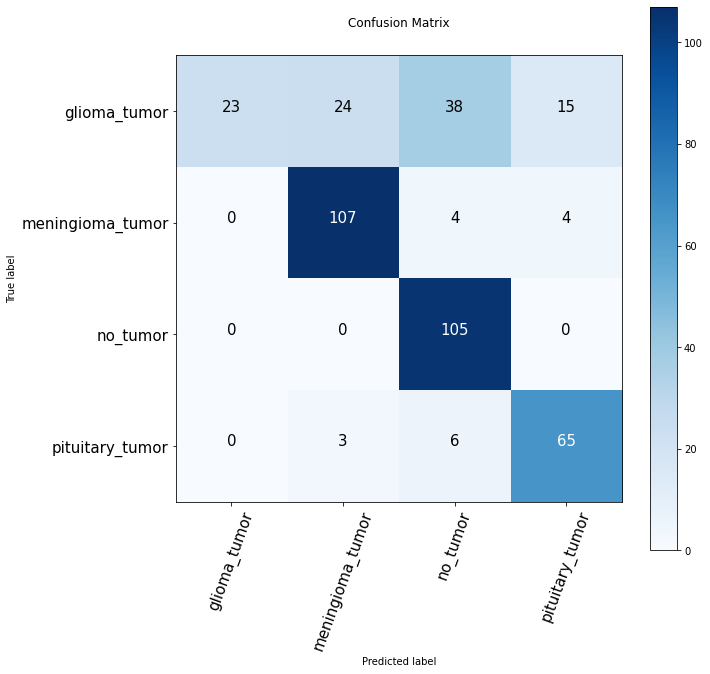

In [33]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(10, 10),
                      text_size=15,
                      norm=False,
                      savefig=True)

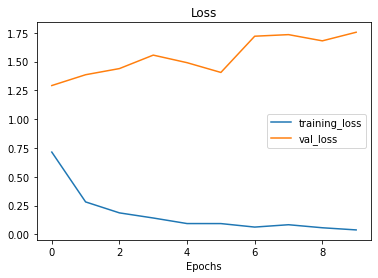

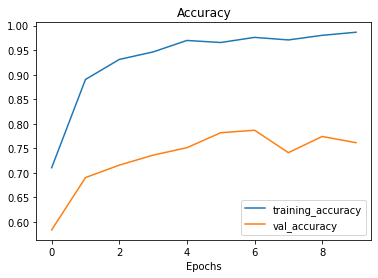

In [34]:
plot_loss_curves(history_efficientnetb0)

In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       1.00      0.23      0.37       100
           1       0.80      0.93      0.86       115
           2       0.69      1.00      0.81       105
           3       0.77      0.88      0.82        74

    accuracy                           0.76       394
   macro avg       0.81      0.76      0.72       394
weighted avg       0.82      0.76      0.72       394



In [36]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.3739837398373984,
  'precision': 1.0,
  'recall': 0.23,
  'support': 100},
 '1': {'f1-score': 0.8594377510040161,
  'precision': 0.7985074626865671,
  'recall': 0.9304347826086956,
  'support': 115},
 '2': {'f1-score': 0.813953488372093,
  'precision': 0.6862745098039216,
  'recall': 1.0,
  'support': 105},
 '3': {'f1-score': 0.8227848101265823,
  'precision': 0.7738095238095238,
  'recall': 0.8783783783783784,
  'support': 74},
 'accuracy': 0.7614213197969543,
 'macro avg': {'f1-score': 0.7175399473350225,
  'precision': 0.8146478740750032,
  'recall': 0.7597032902467685,
  'support': 394},
 'weighted avg': {'f1-score': 0.7172205776082197,
  'precision': 0.8150992043154105,
  'recall': 0.7614213197969543,
  'support': 394}}

In [37]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'glioma_tumor': 0.3739837398373984,
 'meningioma_tumor': 0.8594377510040161,
 'no_tumor': 0.813953488372093,
 'pituitary_tumor': 0.8227848101265823}

In [38]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
1,meningioma_tumor,0.859438
3,pituitary_tumor,0.822785
2,no_tumor,0.813953
0,glioma_tumor,0.373984


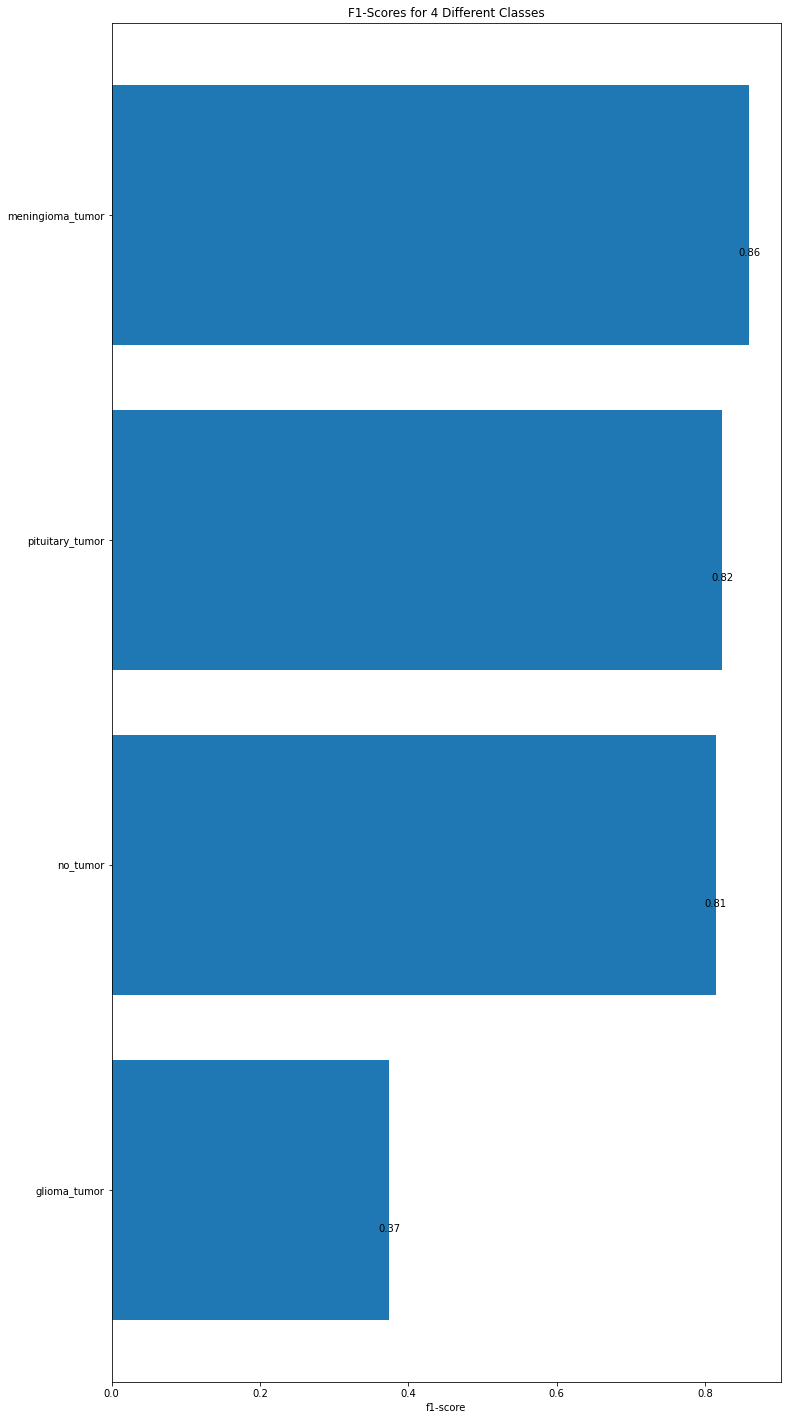

In [39]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 4 Different Classes for EfficientnetB0")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.0*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

# MobileNetV3Small (Fully Trainable)

In [45]:
# Setup base model and freeze its layers (this will extract features)
base_model_2 = tf.keras.applications.MobileNetV3Small(include_top=False)
base_model_2.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model_2(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model_mobilenetv3 = tf.keras.Model(inputs, outputs)

In [46]:
# Get a summary of our model
model_mobilenetv3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
MobilenetV3small (Functional (None, 1, 1, 1024)        1529968   
_________________________________________________________________
global_average_pooling (Glob (None, 1024)              0         
_________________________________________________________________
output_layer (Dense)         (None, 4)                 4100      
Total params: 1,534,068
Trainable params: 4,100
Non-trainable params: 1,529,968
_________________________________________________________________


In [50]:
# Unfreeze all of the layers in the base model
base_model_2.trainable = True



In [51]:
# Recompile model with lower learning rate
model_mobilenetv3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [52]:
# What layers in the model are trainable?
for layer in model_mobilenetv3.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
MobilenetV3small True
global_average_pooling True
output_layer True


In [53]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 True
1 rescaling_2 True
2 Conv True
3 Conv/BatchNorm True
4 tf.__operators__.add_28 True
5 re_lu_33 True
6 tf.math.multiply_28 True
7 multiply_19 True
8 expanded_conv/depthwise/pad True
9 expanded_conv/depthwise True
10 expanded_conv/depthwise/BatchNorm True
11 re_lu_34 True
12 expanded_conv/squeeze_excite/AvgPool True
13 expanded_conv/squeeze_excite/Conv True
14 expanded_conv/squeeze_excite/Relu True
15 expanded_conv/squeeze_excite/Conv_1 True
16 tf.__operators__.add_29 True
17 re_lu_35 True
18 tf.math.multiply_29 True
19 expanded_conv/squeeze_excite/Mul True
20 expanded_conv/project True
21 expanded_conv/project/BatchNorm True
22 expanded_conv_1/expand True
23 expanded_conv_1/expand/BatchNorm True
24 re_lu_36 True
25 expanded_conv_1/depthwise/pad True
26 expanded_conv_1/depthwise True
27 expanded_conv_1/depthwise/BatchNorm True
28 re_lu_37 True
29 expanded_conv_1/project True
30 expanded_conv_1/project/BatchNorm True
31 expanded_conv_2/expand True
32 expanded_conv_2/expand/

In [54]:
# Train for 10 epochs
epochs = 10 

history_mobilenetv3 = model_mobilenetv3.fit(train_data,
                      epochs=epochs,
                      validation_data=test_data,
                      validation_steps=int(len(test_data)))

Epoch 1/10
90/90 [==============================] - 51s 480ms/step - loss: 0.7020 - accuracy: 0.7139 - val_loss: 1.1785 - val_accuracy: 0.5838
Epoch 2/10
90/90 [==============================] - 31s 336ms/step - loss: 0.3675 - accuracy: 0.8540 - val_loss: 1.2860 - val_accuracy: 0.6015
Epoch 3/10
90/90 [==============================] - 26s 283ms/step - loss: 0.2987 - accuracy: 0.8840 - val_loss: 1.0942 - val_accuracy: 0.6878
Epoch 4/10
90/90 [==============================] - 25s 270ms/step - loss: 0.2432 - accuracy: 0.9080 - val_loss: 1.3627 - val_accuracy: 0.6827
Epoch 5/10
90/90 [==============================] - 24s 256ms/step - loss: 0.1953 - accuracy: 0.9275 - val_loss: 1.0555 - val_accuracy: 0.7132
Epoch 6/10
90/90 [==============================] - 22s 239ms/step - loss: 0.1972 - accuracy: 0.9240 - val_loss: 1.5634 - val_accuracy: 0.6954
Epoch 7/10
90/90 [==============================] - 22s 237ms/step - loss: 0.1660 - accuracy: 0.9390 - val_loss: 1.5329 - val_accuracy: 0.7234

In [55]:
# Save model to drive so it can be used later 
model_mobilenetv3.save("drive/My Drive/Brain_Tumor_Data/mobilenetv3_model.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [56]:
# Evaluate the model
loaded_loss_2, loaded_accuracy_2 = model_mobilenetv3.evaluate(test_data)
loaded_loss_2, loaded_accuracy_2

13/13 [==============================] - 1s 78ms/step - loss: 1.8506 - accuracy: 0.7335


(1.8505512475967407, 0.7335025668144226)

In [57]:
# Make predictions with model
pred_probs_2 = model_mobilenetv3.predict(test_data, verbose=1) # set verbosity to see how long it will take

13/13 [==============================] - 2s 70ms/step


In [59]:
# How many predictions are there?
len(pred_probs_2)

394

In [60]:
# How do they look?
pred_probs_2[:10]

array([[1.4653178e-02, 9.6411884e-01, 5.8775037e-03, 1.5350578e-02],
       [5.4814192e-03, 9.3550628e-01, 4.1319773e-02, 1.7692626e-02],
       [1.3773730e-04, 9.7519696e-01, 5.2274694e-03, 1.9437829e-02],
       [1.1345501e-02, 7.5391960e-01, 1.2996017e-03, 2.3343524e-01],
       [1.1345501e-02, 7.5391960e-01, 1.2996017e-03, 2.3343524e-01],
       [3.9297802e-06, 9.6522349e-01, 1.2559231e-04, 3.4646984e-02],
       [1.0769020e-03, 2.9829621e-01, 7.0022410e-01, 4.0276072e-04],
       [1.7338692e-05, 8.5707659e-01, 1.1349676e-01, 2.9409304e-02],
       [2.1411230e-05, 9.9012458e-01, 6.1365883e-03, 3.7174670e-03],
       [6.1078267e-06, 9.9104148e-01, 7.7319373e-03, 1.2204051e-03]],
      dtype=float32)

In [61]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs_2[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs_2[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs_2[0].argmax()}")

Number of prediction probabilities for sample 0: 4
What prediction probability sample 0 looks like:
 [0.01465318 0.96411884 0.0058775  0.01535058]
The class with the highest predicted probability by the model for sample 0: 1


In [62]:
# Get the class predicitons of each label
pred_classes_2 = pred_probs_2.argmax(axis=1)

# How do they look?
pred_classes_2[:100]

array([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 2, 1, 1, 3, 2, 2, 3, 1, 1, 1, 1, 3, 1, 0, 2, 1, 1,
       1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 3, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 3, 0, 3, 1, 3, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1])

In [63]:
y_labels_2 = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels_2.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels_2[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [64]:
# How many labels are there? (should be the same as how many prediction probabilities we have)
len(y_labels_2)

394

In [66]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy_2 = accuracy_score(y_labels_2, pred_classes_2)
sklearn_accuracy

0.733502538071066

In [67]:
# Does the evaluate method compare to the Scikit-Learn measured accuracy?
import numpy as np
print(f"Close? {np.isclose(loaded_accuracy_2, sklearn_accuracy_2)} | Difference: {loaded_accuracy_2 - sklearn_accuracy_2}")

Close? True | Difference: 2.874335658376026e-08


In [68]:
# We'll import our make_confusion_matrix function from https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py 
# But if you run it out of the box, it doesn't really work for 101 classes...
# the cell below adds a little functionality to make it readable.
from helper_functions import make_confusion_matrix

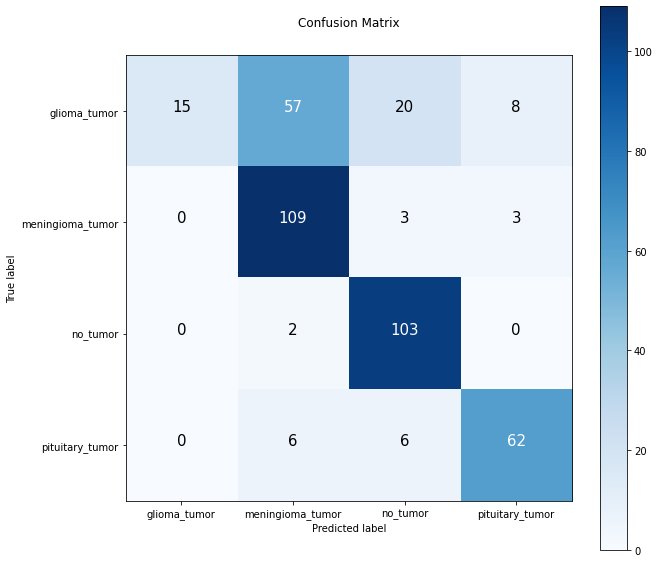

In [69]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels_2,
                      y_pred=pred_classes_2,
                      classes=class_names,
                      figsize=(10, 10),
                      text_size=15,
                      norm=False,
                      savefig=True)

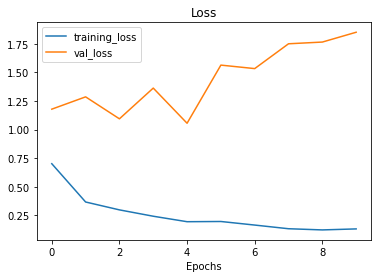

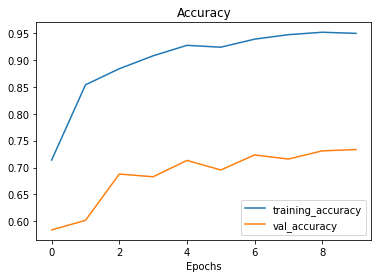

In [70]:
plot_loss_curves(history_mobilenetv3)

In [71]:
from sklearn.metrics import classification_report
print(classification_report(y_labels_2, pred_classes_2))

              precision    recall  f1-score   support

           0       1.00      0.15      0.26       100
           1       0.63      0.95      0.75       115
           2       0.78      0.98      0.87       105
           3       0.85      0.84      0.84        74

    accuracy                           0.73       394
   macro avg       0.81      0.73      0.68       394
weighted avg       0.80      0.73      0.68       394



In [72]:
# Get a dictionary of the classification report
classification_report_dict_2 = classification_report(y_labels_2, pred_classes_2, output_dict=True)
classification_report_dict_2

{'0': {'f1-score': 0.2608695652173913,
  'precision': 1.0,
  'recall': 0.15,
  'support': 100},
 '1': {'f1-score': 0.7543252595155708,
  'precision': 0.6264367816091954,
  'recall': 0.9478260869565217,
  'support': 115},
 '2': {'f1-score': 0.8691983122362869,
  'precision': 0.7803030303030303,
  'recall': 0.9809523809523809,
  'support': 105},
 '3': {'f1-score': 0.8435374149659863,
  'precision': 0.8493150684931506,
  'recall': 0.8378378378378378,
  'support': 74},
 'accuracy': 0.733502538071066,
 'macro avg': {'f1-score': 0.6819826379838089,
  'precision': 0.814013720101344,
  'recall': 0.7291540764366851,
  'support': 394},
 'weighted avg': {'f1-score': 0.6764516570008196,
  'precision': 0.804115134861342,
  'recall': 0.733502538071066,
  'support': 394}}

In [73]:
# Create empty dictionary
class_f1_scores_2 = {}
# Loop through classification report items
for k, v in classification_report_dict_2.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores_2[class_names[int(k)]] = v["f1-score"]
class_f1_scores_2

{'glioma_tumor': 0.2608695652173913,
 'meningioma_tumor': 0.7543252595155708,
 'no_tumor': 0.8691983122362869,
 'pituitary_tumor': 0.8435374149659863}

In [74]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores_2 = pd.DataFrame({"class_name": list(class_f1_scores_2.keys()),
                          "f1-score": list(class_f1_scores_2.values())}).sort_values("f1-score", ascending=False)
f1_scores_2

,class_name,f1-score
2,no_tumor,0.869198
3,pituitary_tumor,0.843537
1,meningioma_tumor,0.754325
0,glioma_tumor,0.260870


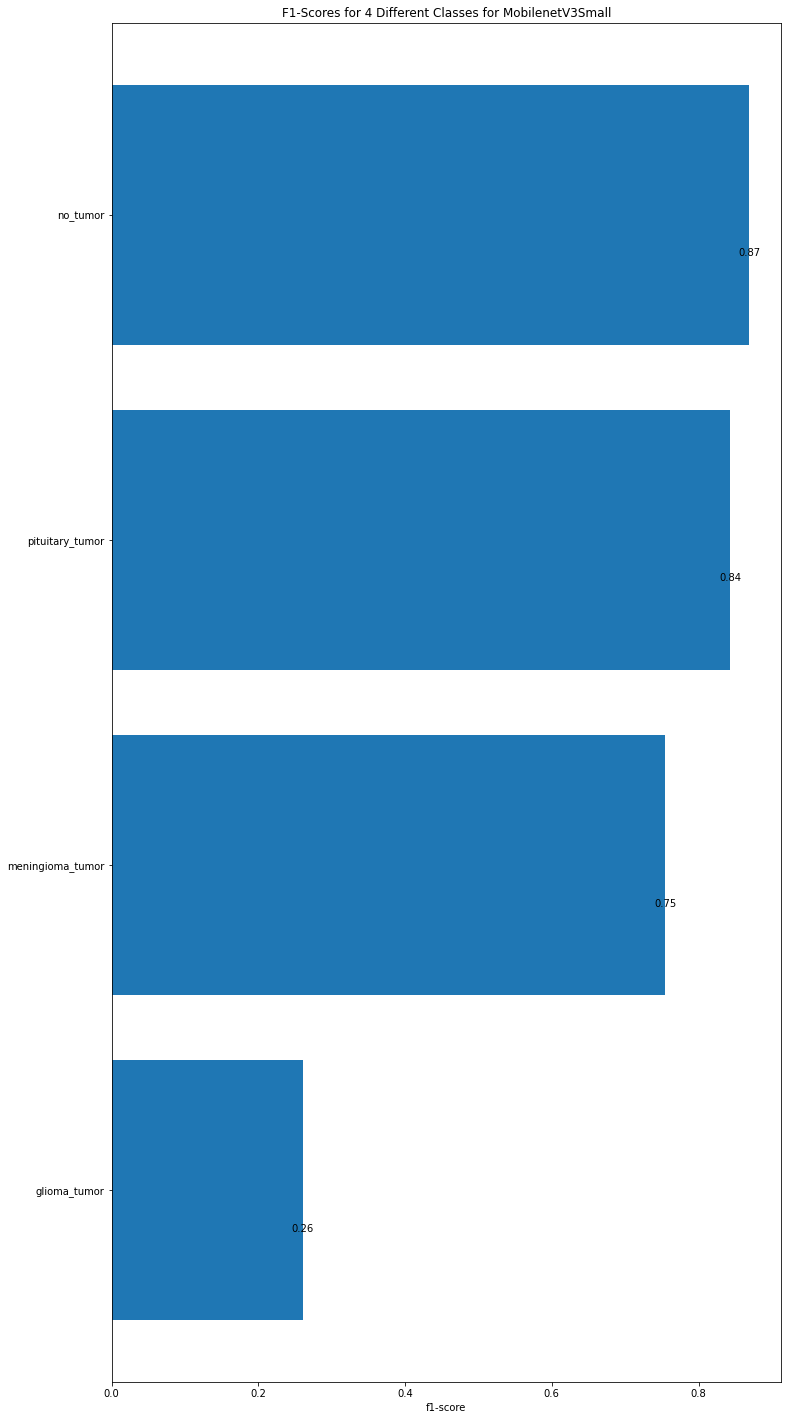

In [76]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores_2)), f1_scores_2["f1-score"].values)
ax.set_yticks(range(len(f1_scores_2)))
ax.set_yticklabels(list(f1_scores_2["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 4 Different Classes for MobilenetV3Small")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.0*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)